In [51]:
import scipy.io as sio
import pandas as pd
import numpy as np
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tqdm
import matplotlib.pyplot as plt

torch.manual_seed(1)

In [15]:
DIM_SIZE = 200
NUM_NEG_SAMPLES = 1

In [3]:
lex = sio.loadmat('data/gold_standard.mat')['gold_standard']['map']
world = sio.loadmat('data/world.mat')['world']
corpus = sio.loadmat('data/corpus.mat')['corpus']

# World

In [4]:
def get_world():
    
    world = sio.loadmat('data/world.mat')['world']
    world = world[0][0]
    
    word_idx = world[0][0] - 1
    words = list(itertools.chain.from_iterable(map(list, world[1][0])))  
    word_dict = dict(zip(word_idx, words))
    
    obj_idx = world[3][0] - 1
    objs = list(itertools.chain.from_iterable(map(list, world[4][0])))  
    obj_dict = dict(zip(obj_idx, objs))
    
    return word_dict, obj_dict

# Gold Standard Lexicon

In [5]:
def get_gold_lexicon(word_dict, obj_dict):
    
    lex = sio.loadmat('data/gold_standard.mat')['gold_standard']['map']
    lex = lex[0][0]
    
    lex_dict_index = {}
    lex_dict_readable = {}
    for i, j in zip(lex[0], lex[1]):
        lex_dict_index[i-1] = j-1
        lex_dict_readable[word_dict[i-1]] = obj_dict[j-1]
        
    return lex_dict_index, lex_dict_readable

# Corpus


In [6]:
def get_corpus(word_dict, obj_dict):
    
    corpus = sio.loadmat('data/corpus.mat')['corpus']
    corpus = corpus[0]
    
    corpus_idx = []
    corpus_readable = []
    for pair in corpus:
        
        scene = list(pair[0][0]-1)
        utt = list(pair[1][0]-1)
        new_pair = {'scene': scene, 'utt': utt}
        corpus_idx.append(new_pair)
        
        scene_word = list(map(lambda x: obj_dict[x], scene))
        utt_word = list(map(lambda x: word_dict[x], utt))
        new_pair_readable = {'scene': scene_word, 'utt': utt_word}
        corpus_readable.append(new_pair_readable)
    
    return corpus_idx, corpus_readable

# Helper Functions

In [7]:
word_dict, obj_dict = get_world()
gold_idx, gold_readable = get_gold_lexicon(word_dict, obj_dict)
corpus_idx, corpus_readable = get_corpus(word_dict, obj_dict)

vocab_len = len(word_dict)
obj_len = len(obj_dict)

In [8]:
def get_alignments(pair):
    utt, scene = pair['utt'], pair['scene']
    combos = list(itertools.product(utt, scene))
    return combos

In [ ]:
# def create_embeddings(vocab_len, obj_len):
#     # Access with torch.LongTensor()
#     # word_embeddings(torch.LongTensor([0, 1, 2])).shape = (3, 200)
#     word_embeddings = EmbeddingModeler(vocab_len, DIM_SIZE)
#     obj_embeddings = EmbeddingModeler(obj_len, DIM_SIZE)
#     return word_embeddings, obj_embeddings

In [171]:
class APEmbeddingModeler(nn.Module):

    def __init__(self, vocab_len, obj_len):
        super(APEmbeddingModeler, self).__init__()
        self.word_embeddings = nn.Parameter(torch.randn((vocab_len, DIM_SIZE)))
        self.object_embeddings = nn.Parameter(torch.randn((DIM_SIZE, obj_len)))
        self.parameters = nn.ParameterList([self.word_embeddings, self.object_embeddings])
    
    def forward(self, word, obj, neg_samples):
       

        
        word_embed = self.word_embeddings[word].view(1, -1) #1x200 and 200 by 50
        obj_embeds = F.cosine_similarity(word_embed, self.object_embeddings.t())
        obj_embed = obj_embeds[obj]
        neg_embeds = obj_embeds[neg_samples]

        
        #         word_embeds = self.word_embeddings(word).view((len(word), -1))
#         obj_embeds = self.object_embeddings(obj).view((len(obj), -1))
#         neg_sample_embeds = self.object_embeddings(neg_samples).view((len(neg_samples), -1))
        
        
        

        #TODO: PUT FORWARD ALL IN HERE, WHERE FORWARD IS JUST SELECTION OF EMBEDDINGs
        
        return word_embed, obj_embed, neg_embeds

In [109]:
x = np.array([1, 2, 3, 5, 6])


array([1, 2, 2])

In [137]:
x = torch.randn((5, 10))
y = torch.randn((1, 5))


tensor([[ 1.1281, -1.5250, -1.4423, -1.8166,  1.8343, -1.4280,  1.2984, -1.3595,
          2.3639, -0.5384]])

torch.Size([5])

In [151]:
F.cosine_similarity(y, x.t())

tensor([ 0.6572, -0.4282, -0.4861, -0.4041,  0.8624, -0.8046,  0.6206, -0.4406,
         0.7228, -0.5040])

In [219]:
def train_embeddings(corpus_idx, corpus_readable, vocab_len, obj_len, loss_type, lr=0.001, epochs=10):
    
    if loss_type == 'anti-polysemy':
        model = APEmbeddingModeler(vocab_len, obj_len)
    else:
        pass #TODO!!
    
    losses = []
    optimizer = optim.SGD(model.parameters(), lr=lr) #TODO: MAKE ONE MODEL WITH BOTH EMBEDDINGS AS ELEMENTS
    for epoch in tqdm.tqdm_notebook(range(epochs)):
        total_loss = 0
        for i, pair in enumerate(corpus_idx):
            
#             readable = corpus_readable[i]
#             print(f"UTT: {pair['utt']}")
#             print(f"SCENE: {pair['scene']}")
#             print(f"UTT: {readable['utt']}")
#             print(f"SCENE: {readable['scene']}")
                  
            model.zero_grad()
            
            combos = get_alignments(pair)
            loss = 0
            for combo in combos:
                
                if loss_type == 'anti-polysemy':
                    loss += apl_loss(model, obj_len, combo, pair['scene'])
                elif loss_type == 'anti-synonymy':
                    loss += asl_loss(model, vocab_len, combo)
                else:
                    loss += joint_loss(model, obj_len, vocab_len, combo)
                    
#                 print(loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

#             break
        losses.append(total_loss)
#         print(total_loss)
#     print(losses)  # The los
    
    return losses
    
    

# Neural Network Functions

INPUT needs to be a single world
Run through an NN from 200 x H x 200
First embedding space is word embedding
Final embedding space is object embedding space.
In this sense, the object embedding space is learned?
Find the hinge loss between input word and chosen object, doesn't make sense??

Input should be a single word and a single referent.
Then we need to find some relationship between them.
Cosine should be that layer.
Cosine should then lead to some scalar cos(w, o), which is input into a contrastive loss function with some other
negative samples. Using backpropagation, all embeddings should then be learned.


How does contrastive loss actually work?

In [154]:
def apl_loss(model, obj_len, combo, scene):
    
    word, obj = combo[0], combo[1]
    neg_samples = np.random.choice(np.setdiff1d(np.arange(obj_len), scene), NUM_NEG_SAMPLES, replace=False)

    word_embedding, obj_embedding, neg_sample_embeddings = model(word, obj, neg_samples)
    
    margin = 1 - obj_embedding +\
    neg_sample_embeddings
    
#     print("MARGIN")
#     print(margin)
    
    loss = torch.sum(
        torch.max(
            torch.zeros(NUM_NEG_SAMPLES),
            margin
        )
    )
#     print("LOSS")
#     print(loss)
    return loss

def asl_loss(word_embeddings, object_embeddings, vocab_len):
    pass

def joint_loss(word_embeddings, object_embeddings, obj_len, vocab_len):
    pol_loss = apl_loss()
    syn_loss = asl_loss()
    return torch.add(pol_loss, syn_loss)

In [225]:
all_losses = []
# lrs = np.linspace(0.01, 0.9, 10)
lrs = [0.9]
epoch = 100
for lr in tqdm.tqdm_notebook(lrs):
    losses = train_embeddings(corpus_idx, corpus_readable, vocab_len, obj_len, 'anti-polysemy', lr, epoch)
    all_losses.append(losses)

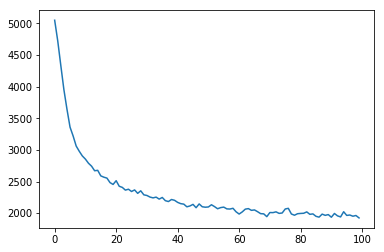

In [226]:
plt.plot(np.arange(100), all_losses[0])

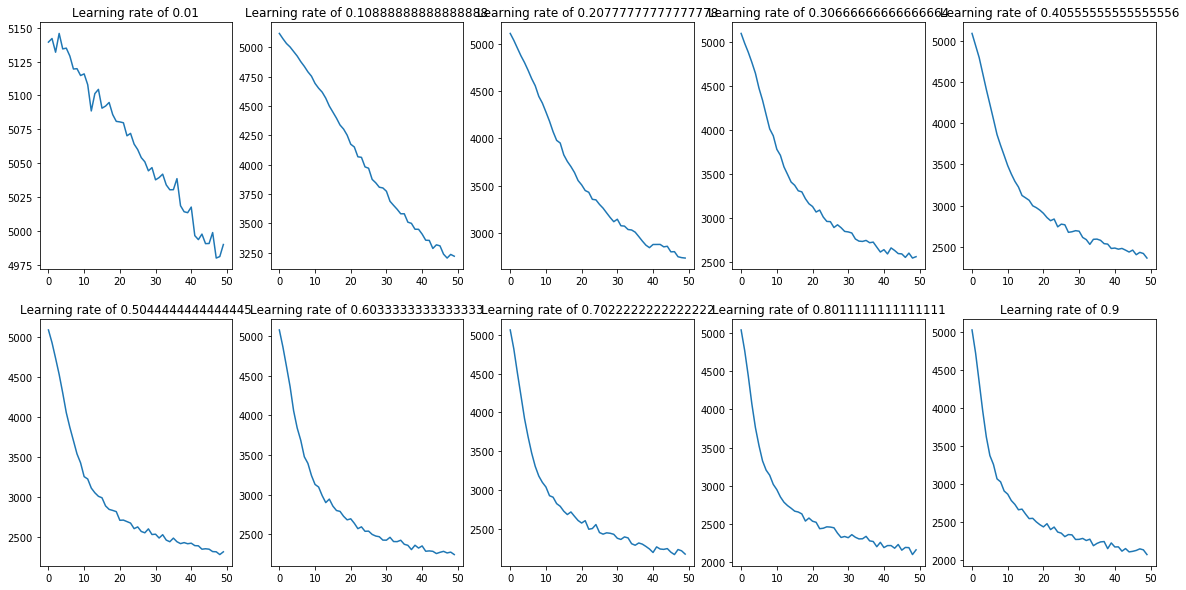

In [224]:
# lrs = np.arange()
# for i, losses in enumerate(all_losses):
#     plt.plot(np.arange(10), losses)
#     plt.title(f'Learning rate of {lrs[i]}')
#     plt.show()
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

all_losses = np.array(all_losses).reshape(2, 5, 100)
for i in range(2):
    for j in range(5):
        ax[i][j].plot(np.arange(50), all_losses[i][j])
        ax[i][j].set_title(f'Learning rate of {lrs[5*i + j]}')

# Framework

In [ ]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
# print the first 3, just so you can see what they look like
print(trigrams[:3])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
#         print(self.embeddings.weight.shape)
        embeds = self.embeddings(inputs).view((1, -1))
#         print(embeds.shape)
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)


In [ ]:
for epoch in range(10):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
#         print(context_idxs)
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)
#         print(log_probs.shape)
        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The los